In [4]:

from whale.data_io.data_loader import WhaleDataModule
import numpy  as np
from matplotlib import pyplot as plt
from whale.utils.spectrogram import show_spectrogram, cal_spectrogram
import obspy
import pandas as pd
from obspy import read, UTCDateTime

def read_waveform_spec(meta_data,comp):

        time_R_max = obspy.UTCDateTime(meta_data["time_R_max"])
        start_time = obspy.UTCDateTime(meta_data["time_window_start"])
        end_time = obspy.UTCDateTime(meta_data["time_window_end"])

        target_time_R_max = time_R_max - start_time
        target_time_R_max = np.float32(target_time_R_max)


        tr = obspy.read(
            meta_data['file_path'].replace("CHANNEL", comp),
            starttime=start_time,
            endtime=end_time,
        )
        input_waveform = tr[0].data
        input_spec, _, _ = cal_spectrogram(
                input_waveform,
                samp_rate=100,
                per_lap=0.9,
                wlen=0.5,
                mult=4,
            )

        return input_waveform,input_spec
whale_dm = WhaleDataModule(
    data_dir="/network/projects/aia/whale_call/LABELS/BWC_3CH_HQ", batch_size=1,data_type="spec"
)
whale_dm.setup()
ds_sel = whale_dm.train_ds
idx_sel = 815
sig_length = 1601
dt = 0.01
t_axis = np.arange(0,sig_length)*dt
label_dict = {0:'Noise',1:'BW Call'}
data_sel = ds_sel[idx_sel]



In [5]:
data_sel['meta_data']

{'file_path': '/network/projects/aia/whale_call/FILT_10_32/20211002/2021.10.02.CN.PMAQ..CHANNEL.SAC',
 'time_window_start': '2021-10-02 07:13:21.230000',
 'time_window_end': '2021-10-02 07:13:37.230000',
 'time_R_max': '2021-10-02 07:13:33.015723520',
 'time_call_start': '2021-10-02 07:13:29.015723520',
 'time_call_end': '2021-10-02 07:13:37.015723520',
 'R': 7.394051571470975,
 'SNR': 8.133923317964895,
 'group_id': 2519,
 'station_code': 'PMAQ',
 'whale_type': 'bw',
 'component': 'HHE HHN HHZ'}

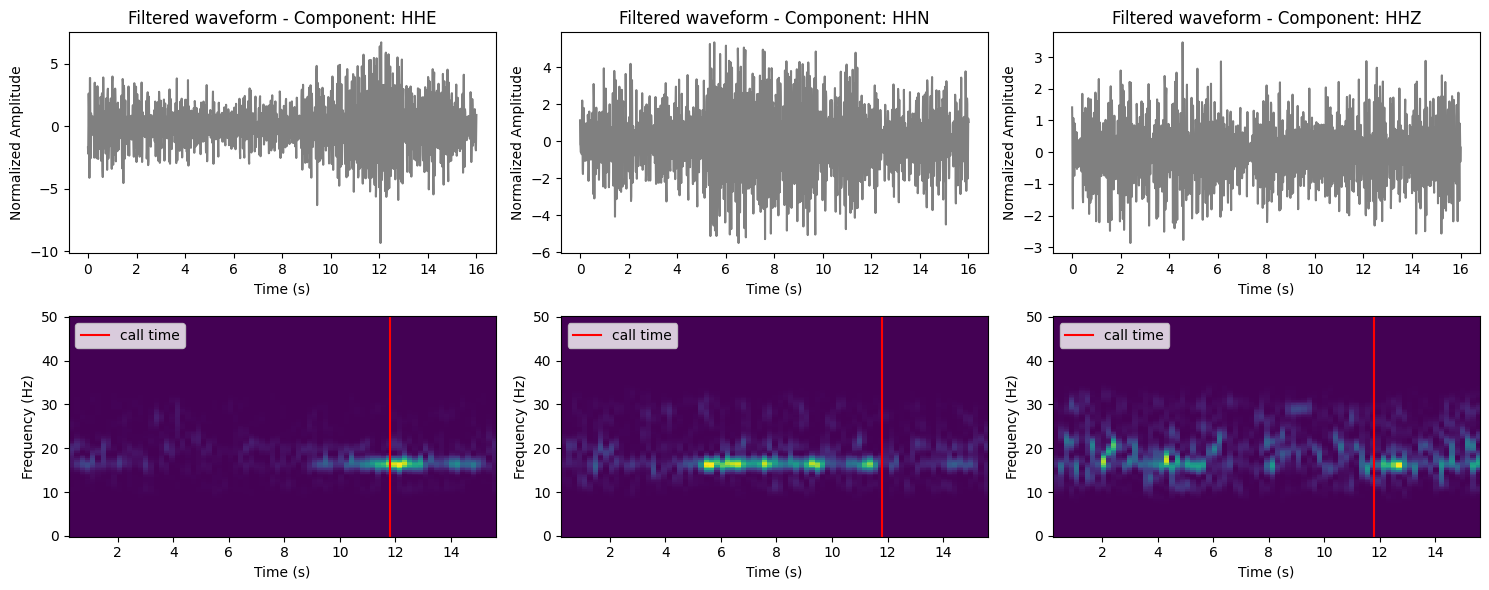

In [6]:


fig,axs = plt.subplots(2,3,figsize=(15,6))
spec_list = []
for (i,comp) in enumerate(data_sel['meta_data']['component'].split(' ')):

    sig, spectrogram = read_waveform_spec(data_sel['meta_data'],comp)
    spec_list.append(spectrogram)
    axs[0][i].plot(t_axis,sig,color='grey');
    axs[0][i].set_title('Filtered waveform - Component: {}'.format(comp))
    # add axis labels
    axs[0][i].set_xlabel('Time (s)')
    axs[0][i].set_ylabel('Normalized Amplitude')

    # plot spectrogram and add vertical lines representing target time and predicted time
    ## first get the time and freq bins
    _,freq,time=cal_spectrogram(sig,samp_rate=100,per_lap=0.9, wlen=0.5, mult=4)
    # calculate half bin width
    halfbin_time = (time[1] - time[0]) / 2.0
    halfbin_freq = (freq[1] - freq[0]) / 2.0
    # this method is much much faster!
    specgram = np.flipud(spectrogram)
    # center bin
    extent = (
        time[0] - halfbin_time,
        time[-1] + halfbin_time,
        freq[0] - halfbin_freq,
        freq[-1] + halfbin_freq,
    )
    axs[1][i].imshow(specgram, interpolation="nearest", extent=extent)

    # show_spectrogram(sig[0],axes=axs[1][i],samp_rate=100,per_lap=0.9, wlen=0.5, mult=4)
    time_r_max = data_sel['target_time'] * (ds_sel.target_time_max_val - ds_sel.target_time_min_val) + ds_sel.target_time_min_val
    axs[1][i].axvline(x=time_r_max,color='red')
    axs[1][i].set_xlim([0,time[-1]])
    axs[1][i].axis("tight")
    # ax.grid(False)

    # add axis labels
    axs[1][i].set_xlabel('Time (s)')
    axs[1][i].set_ylabel('Frequency (Hz)')
    # show legend
    axs[1][i].legend(['call time'])

plt.tight_layout()
# fig.savefig('prediction_examples_baseline_LSTM_cls_reg.png',dpi=300)

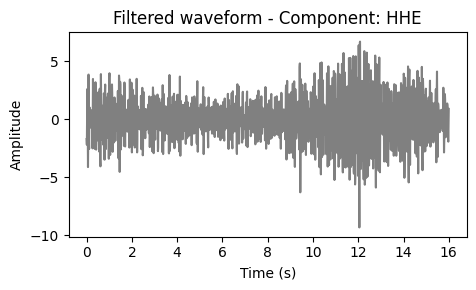

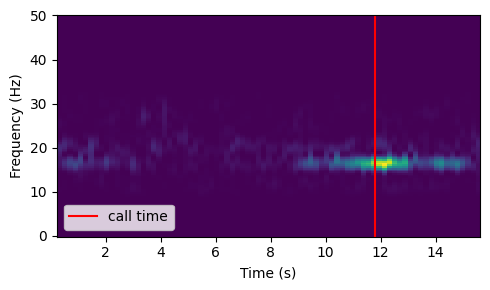

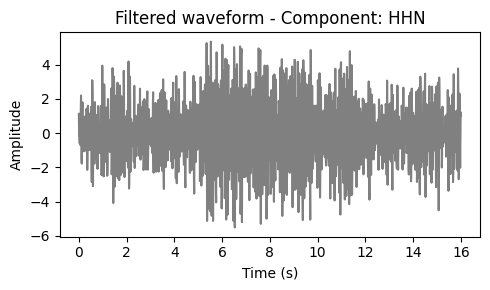

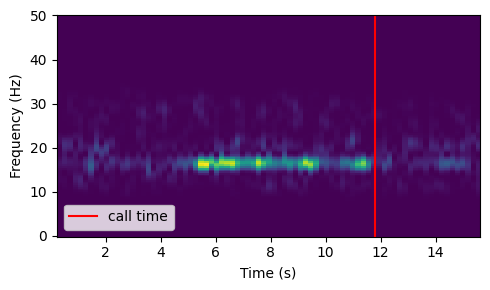

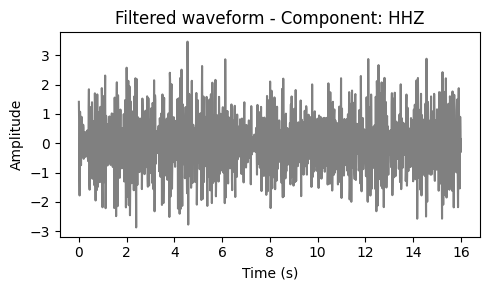

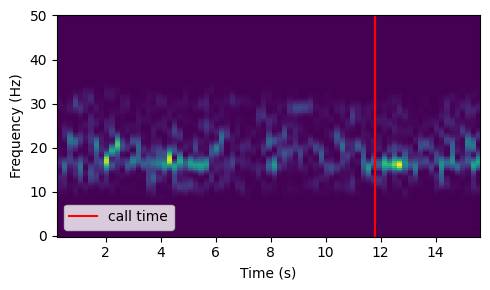

In [13]:
def read_waveform_spec(meta_data,comp):

        time_R_max = obspy.UTCDateTime(meta_data["time_R_max"])
        start_time = obspy.UTCDateTime(meta_data["time_window_start"])
        end_time = obspy.UTCDateTime(meta_data["time_window_end"])

        target_time_R_max = time_R_max - start_time
        target_time_R_max = np.float32(target_time_R_max)


        tr = obspy.read(
            meta_data['file_path'].replace("CHANNEL", comp),
            starttime=start_time,
            endtime=end_time,
        )
        input_waveform = tr[0].data
        input_spec, _, _ = cal_spectrogram(
                input_waveform,
                samp_rate=100,
                per_lap=0.9,
                wlen=0.5,
                mult=4,
            )

        return input_waveform,input_spec

spec_list = []
for (i,comp) in enumerate(data_sel['meta_data']['component'].split(' ')):

    sig, spectrogram = read_waveform_spec(data_sel['meta_data'],comp)
    spec_list.append(spectrogram)

    fig,ax = plt.subplots(1,1,figsize=(5,3))
    ax.plot(t_axis,sig,color='grey');
    ax.set_title('Filtered waveform - Component: {}'.format(comp))
    # add axis labels
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    plt.tight_layout()
    fig.savefig(f'waveform_{comp}.png',dpi=300)
    # plot spectrogram and add vertical lines representing target time and predicted time
    ## first get the time and freq bins
    _,freq,time=cal_spectrogram(sig,samp_rate=100,per_lap=0.9, wlen=0.5, mult=4)
    # calculate half bin width
    halfbin_time = (time[1] - time[0]) / 2.0
    halfbin_freq = (freq[1] - freq[0]) / 2.0
    # this method is much much faster!
    specgram = np.flipud(spectrogram)
    # center bin
    extent = (
        time[0] - halfbin_time,
        time[-1] + halfbin_time,
        freq[0] - halfbin_freq,
        freq[-1] + halfbin_freq,
    )

    fig,ax = plt.subplots(1,1,figsize=(5,3))
    ax.imshow(specgram, interpolation="nearest", extent=extent)

    # show_spectrogram(sig[0],axes=axs[1][i],samp_rate=100,per_lap=0.9, wlen=0.5, mult=4)
    time_r_max = data_sel['target_time'] * (ds_sel.target_time_max_val - ds_sel.target_time_min_val) + ds_sel.target_time_min_val
    ax.axvline(x=time_r_max,color='red')
    ax.set_xlim([0,time[-1]])
    ax.axis("tight")
    # ax.grid(False)

    # add axis labels
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    # show legend
    ax.legend(['call time'],loc='lower left')

    plt.tight_layout()
    fig.savefig(f'spec_{comp}.png',dpi=300)

# fig.savefig('prediction_examples_baseline_LSTM_cls_reg.png',dpi=300)

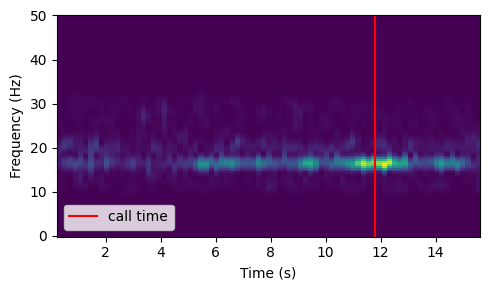

In [10]:
fig,ax = plt.subplots(1,1,figsize=(5,3))
input_spec  = data_sel['spec']
input_spec = np.flipud(input_spec.T)
ax.imshow(input_spec, interpolation="nearest", extent=extent)

# show_spectrogram(sig[0],axes=axs[1][i],samp_rate=100,per_lap=0.9, wlen=0.5, mult=4)
time_r_max = data_sel['target_time'] * (ds_sel.target_time_max_val - ds_sel.target_time_min_val) + ds_sel.target_time_min_val
ax.axvline(x=time_r_max,color='red')
ax.set_xlim([0,time[-1]])
ax.axis("tight")
# ax.grid(False)

# add axis labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
# show legend
ax.legend(['call time'],loc='lower left')
plt.tight_layout()
fig.savefig(f'spec_avg.png',dpi=300)